In [1]:
import sys
sys.path.append("../src")

from dataloader import *

In [2]:
dataloader = DataLoader()
train_set, eval_set, test = dataloader.run()

preprocessor = PreProcess(X_tr=train_set["X"])
train_set["X"] = preprocessor.transform(X=train_set["X"])
eval_set["X"] = preprocessor.transform(X=eval_set["X"])
test = preprocessor.transform(X=test)

Loading label encoder


In [3]:
cat_features = list(train_set["X"].dtypes[train_set["X"].dtypes == "category"].keys())

In [4]:
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error

In [5]:
class RmsleObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        result = []
        for index in range(len(targets)):
            der1 = np.log1p(approxes[index]) - np.log1p(targets[index])
            der2 = -1

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result
    
class RmsleMetric(object):
    def get_final_error(self, error, weight):
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((approx[i] - target[i])**2)

        return error_sum, weight_sum


* baseline_version_1  
    "loss_function" : "RMSE",  
    "eval_metric" : RmsleMetric(),   
    "iterations" : 1000,   
    "learning_rate" : 0.01,   
    "depth" : 4,  
    "random_seed" : 0  


In [7]:
tune_parameters = {
    "loss_function" : "RMSE",
    "eval_metric" : RmsleMetric(), 
    "iterations" : 1000, 
    "learning_rate" : 0.01, 
    "depth" : 4, 
    # "l2_leaf_reg" : 64, 
    "random_seed" : 0
}

parameters = {
    "cat_features" : cat_features, 
    "eval_set" : (eval_set["X"], eval_set["y"]), 
    "verbose" : False, 
    "plot" : True, 
    "early_stopping_rounds" : 100
    }

model = CatBoostRegressor(**tune_parameters)
model.fit(X=train_set["X"], 
          y=train_set["y"], 
          **parameters)
y_val_pred = model.predict(eval_set["X"])
y_val_pred[y_val_pred < 0] = 0
print("Baseline Model Evaluation Set RMSLE : ", mean_squared_log_error(y_true=eval_set["y"], y_pred=y_val_pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Baseline Model Evaluation Set RMSLE :  2.133876046831082


In [8]:
y_pred = model.predict(test)
y_pred[y_pred < 0] = 0

In [9]:
baseline_model_submission = pd.read_csv("../submit/sample_submission.csv")
baseline_model_submission["sales"] = y_pred

In [10]:
baseline_model_submission

,id,sales
0,3000888,2.941821
1,3000889,1.101738
2,3000890,59.194227
3,3000891,2264.622037
4,3000892,1.101738
...,...,...
28507,3029395,259.196020
28508,3029396,239.691965
28509,3029397,1570.496903
28510,3029398,71.816507


In [11]:
baseline_model_submission.to_csv("../submit/baseline_model_iter1000.csv", index=False)

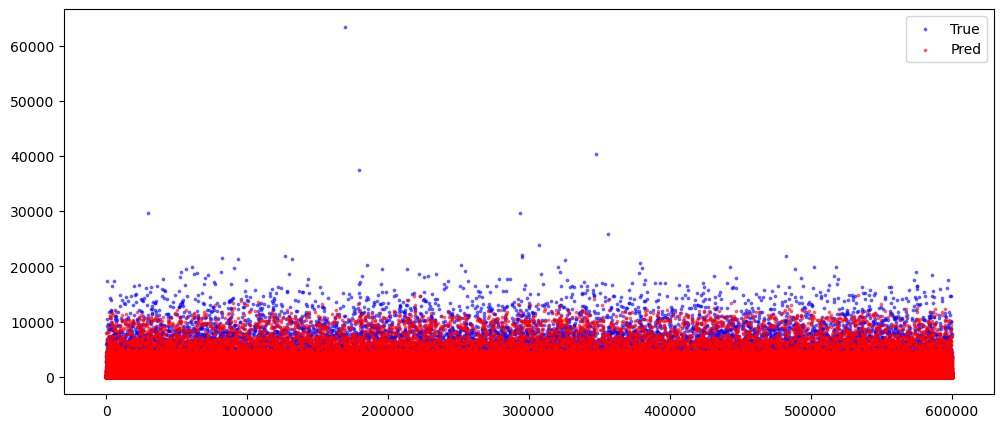

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.scatter(x=eval_set["X"].index ,y=eval_set["y"], alpha=0.5, s=3, marker="o", c="blue", label="True")
plt.scatter(x=eval_set["X"].index ,y=y_val_pred, alpha=0.5, s=3, marker="o", c="red", label="Pred")
plt.legend()
plt.show()
